<font color='RED'>
    
# Implementación del sistema de reconocimiento de imágenes con Pytorch y usando el conjunto de datos CIFAR-10

<font color='BLUE'>
    
# Bibliografia

Se extrajeron las partes más destacadas de los siguientes notebooks:
    
-------[Nb de Pytorch.org](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/17a7c7cb80916fcdf921097825a0f562/cifar10_tutorial.ipynb#scrollTo=5-WzFSa-4b0l)-------
    
-------[Nb de medium.com](https://jovian.ai/sergioalves94/03-cifar10-feedforward/v/1?utm_source=embed)-------
                  

<font color='BLUE'>
    
# Instalación de Pytorch

In [1]:
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet

Solving environment: done

# All requested packages already installed.



<font color='BLUE'>
    
# Importación de las librerías necesarias

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from prettytable import PrettyTable
%matplotlib inline

<font color='BLUE'>
    
# Descarga e información general del Conjunto de datos
Puntos importantes:
    - Se descargan dos conjunto de datos: train y test.
    - ToTensor() convierte datos en el rango 0-255 a 0-1.
    - Se presentan el # de muestras por conjunto, # de 
      clases, clases y un ejemplo, en tablas.
    - Se permutan las dimensiones del tensor de acuerdo 
      a las entradas requeridas por Matplotlib (dimensión 
      RGB al último) con la función permute().

Extracting data/cifar-10-python.tar.gz to data/
+------------------+-----------------+-------------+
| # muestras train | # muestras test | # de clases |
+------------------+-----------------+-------------+
|      50000       |      10000      |      10     |
+------------------+-----------------+-------------+
+------------+
|   clases   |
+------------+
|  airplane  |
| automobile |
|    bird    |
|    cat     |
|    deer    |
|    dog     |
|    frog    |
|   horse    |
|    ship    |
|   truck    |
+------------+
+-------------------------+------------+--------------------+
|  Dimensiones del tensor | # de clase | nombre de la clase |
+-------------------------+------------+--------------------+
| torch.Size([3, 32, 32]) |     9      |       truck        |
+-------------------------+------------+--------------------+


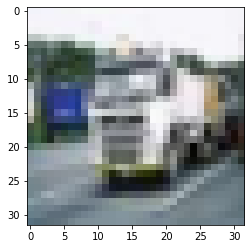

In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor()) 
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

#tablas con información
t = PrettyTable(['# muestras train','# muestras test','# de clases'])
t.add_row([len(dataset),len(test_dataset),len(dataset.classes)])
print(t)

t = PrettyTable(['clases'])
for i in dataset.classes:
    t.add_row([i])
print(t)

#muestra de una imagen del conjunto de entrenamiento
img, label = dataset[1000]
t = PrettyTable(['Dimensiones del tensor','# de clase','nombre de la clase'])
t.add_row([img.shape,label,dataset.classes[label]])
print(t)
plt.imshow(img.permute((1, 2, 0))) 


<font color='BLUE'>
    
# División del conjunto en Train y Validation
Puntos importantes:
    - Se crea un conjunto test con el 10% de muestras del conjunto test.
    - Se usa la función random_split para separar las muestras de manera
      aleatoria del conjunto original con las dimensiones deseadas.

In [4]:
val_size = 5000 #10% del dataset
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

t = PrettyTable(['# muestras train','# muestras validation'])
t.add_row([len(train_ds),len(val_ds)])
print(t)

+------------------+-----------------------+
| # muestras train | # muestras validation |
+------------------+-----------------------+
|      45000       |          5000         |
+------------------+-----------------------+


<font color='BLUE'>
    
# Creación de lotes de datos
Puntos importantes:
    - Cargamos los datos con la función DataLoader(), la cual transforma a
      tensores y agrupa las imágenes por lotes de manera aleatoria (shuffle),
      así, el entrenamiento del modelo será por lotes.
    - Se muestra el primer lote de imágenes.

Dimensión de un lote: torch.Size([32, 3, 32, 32])


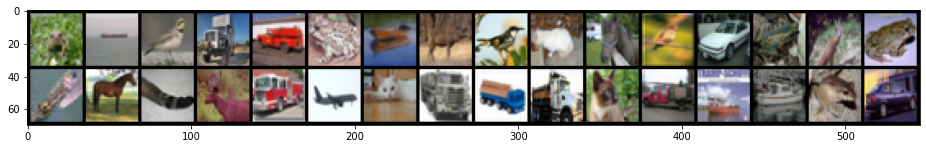

In [5]:
batch_size=32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

for images,_ in train_loader:
    print('Dimensión de un lote:', images.shape)
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<font color='BLUE'>
    
# Construcción del modelo
Puntos importantes:
    - Se define la función accuracy, la cual calcula tiene como entrada las etiquetas 
      reales de cada imagen (labels) y la predicción (outputs), así, calcula y 
      devuelve la relación de las predicciones acertadas entre el total de las
      predicciones.
    - Se define la clase ImageClassificationBase, dentro de la cual, se definen 3 
      funciones. training_step cacula la predicción y la pérdida (usando la función 
      cross_entropy)de cada lote, validation_step cacula la predicción, la precisión y 
      la pérdida (usando cross_entropy)de cada lote del conjunto de validación. 
      validation_epoch_end calcula los promedios de pérdidas y precisiones por épocas.
      epoch_end imprime los resultados.
    - La función fit usa las funciones anteriores para entrenar y validar 
      el modelo, a través de los datos cargados por lotes, así como indicando el
      optimizador (por defecto es SGD)

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Predicciones
        loss = F.cross_entropy(out, labels) # Calculo de perdida
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Predicciones
        loss = F.cross_entropy(out, labels)   # Calculo de perdida
        acc = accuracy(out, labels)           # Calcula la precisión
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # promedio de pérdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # promedio de precisión
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase de entrenamiento
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # fase de validación
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    

<font color='BLUE'>
    
# Funciones para graficar pérdidas y precisiones

In [7]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

<font color='BLUE'>
    
# Disponibilidad y uso del GPU
Puntos importantes:
    - Se define la función get_default_device que busca y GPU si está disponible, sino elige CPU.
    - Se define la función to_device que mueve los tensores al dispositivo disponible.
    - La clase DeviceDataLoader es un conjunto de funciones que vuelve a armar el dataset por lotes, en el dispositivo al que se movieron.

In [16]:
def get_default_device():
    t = PrettyTable(['¿Hay GPU disponible?'])
    if torch.cuda.is_available():
        t.add_row(['Si'])
        print(t)
        return torch.device('cuda')
    else:
        t.add_row(['No'])
        print(t)
        return torch.device('cpu')


device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

##SE MUEVEN LOS DATA LOADERS AL DISPOSITIVO DISPONIBLE
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

    

+----------------------+
| ¿Hay GPU disponible? |
+----------------------+
|          No          |
+----------------------+


<font color='BLUE'>
    
# Entrenamiento del modelo
Puntos importantes:
    - La primera parte de la clase CIFAR10Model define transformaciones lineales para las capas de entrada, salida y una oculta. Después, la función forward convierte los tensores en vectores para después aplicar las transformaciones lineales a cada capa y su respectiva función de activación (en este caso Relu). Finalmente, el modelo se mueve a un GPU si está disponible, después se calcula la primer pérdida y presición con el conjunto de validación y finalmente se entrena y prueba el modelo con la función fit a partir de los conjuntos train y val.

In [17]:
input_size = 3*32*32
output_size = 10

class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out
if torch.cuda.is_available()==True:
    model = to_device(CIFAR10Model(), device)
    history = [evaluate(model, val_loader)]
    print(history)
    epochs=30
    history += fit(epochs, 1e-1, model, train_loader, val_loader)
else:
    model = CIFAR10Model()
    history = [evaluate(model, val_loader)]
    print(history)
    epochs=30
    history += fit(epochs, 1e-1, model, train_loader, val_loader)

[{'val_loss': 2.3051087856292725, 'val_acc': 0.1218152865767479}]
Epoch [0], val_loss: 2.0582, val_acc: 0.2777
Epoch [1], val_loss: 1.8607, val_acc: 0.3223
Epoch [2], val_loss: 2.0813, val_acc: 0.3244
Epoch [3], val_loss: 1.7366, val_acc: 0.3764
Epoch [4], val_loss: 1.6644, val_acc: 0.4120
Epoch [5], val_loss: 1.8477, val_acc: 0.3531
Epoch [6], val_loss: 2.0740, val_acc: 0.3099
Epoch [7], val_loss: 1.5914, val_acc: 0.4405
Epoch [8], val_loss: 2.2976, val_acc: 0.3225
Epoch [9], val_loss: 1.6218, val_acc: 0.4275
Epoch [10], val_loss: 1.5976, val_acc: 0.4323
Epoch [11], val_loss: 1.5104, val_acc: 0.4618
Epoch [12], val_loss: 1.6365, val_acc: 0.4379
Epoch [13], val_loss: 1.6090, val_acc: 0.4445
Epoch [14], val_loss: 1.5308, val_acc: 0.4580
Epoch [15], val_loss: 1.7903, val_acc: 0.4102
Epoch [16], val_loss: 2.0560, val_acc: 0.3521
Epoch [17], val_loss: 1.6121, val_acc: 0.4564
Epoch [18], val_loss: 1.7172, val_acc: 0.4399
Epoch [19], val_loss: 1.7434, val_acc: 0.4325
Epoch [20], val_loss: 1.

<font color='BLUE'>
    
# Gráfica de pérdidas y precisión

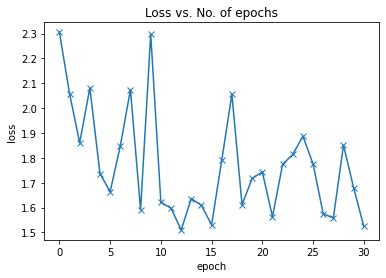

In [18]:
plot_losses(history)

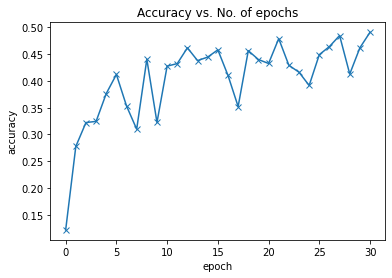

In [19]:
plot_accuracies(history)

<font color='BLUE'>
    
# Evaluación del conjunto test

In [20]:
evaluate(model, test_loader)

{'val_loss': 1.4834613800048828, 'val_acc': 0.49510782957077026}

<font color='BLUE'>
    
# Guardado de los pesos del modelo entrenado

In [21]:
torch.save(model.state_dict(), 'cifar10.pth')

<font color='BLUE'>
    
# Cargamos el modelo guardado para hacer predicciones
Puntos importantes:
    - Se define una función que muestra un lote de imagenes, en donde traspone las dimensiones del tensor de acuerdo al orden requerido por Matplotlib (dimensión 
  RGB al último).
    - Después, convertimos el conjunto test 'lotificado' en un iterador en el que cada elemento del conjunto está asociado a un paso y de esta manera recorremos todo el conjunto. Luego, obtenemos el primer lote y sus respectivas etiquetas del iterador con la función .next() y se muestran en pantalla.
    - A partir de las etiquetas numéricas obtenemos las clases respectivas con dataset.classes[]
    - Asignamos nuestro modelo a la variable net y cargamos los pesos encontrados en el entrenamiento a través de la función load_state_dict(). Después aplicamos el modelo sobre el primer lote de imagenes y obtenemos los valores de las etiquetas con torch.max() (cada predicción tiene 10 números, la posición del valor máximo de la lista corresponde a la posición de la clase predicción) donde a su vez reducimos el tensor a vector para que, finalmente, se muestren las primeras 8 predicciones.

Dimensión de un lote: torch.Size([32, 3, 32, 32])


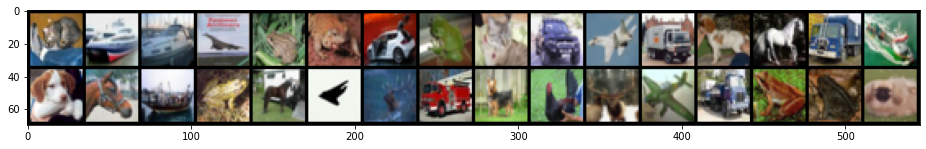

Primeros 8 valores reales:    cat  ship  ship airplane  frog  frog automobile  frog
Primeros 8 predicciones:    cat truck  ship  ship  deer  frog   cat  frog


In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

print('Dimensión de un lote:', images.shape)
plt.figure(figsize=(16,8))
plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
plt.show()

print('Primeros 8 valores reales: ', ' '.join('%5s' % dataset.classes[labels[j]] for j in range(8)))


net = CIFAR10Model()
net.load_state_dict(torch.load('cifar10.pth'))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Primeros 8 predicciones: ', ' '.join('%5s' % dataset.classes[predicted[j]]
                              for j in range(8)))

<font color='BLUE'>
    
# Precisión en el conjunto de prueba
Puntos importantes:
    - Se repiten los pasos de punto anterior, pero ahora sobre todo el conjunto test y se lleva un conteo de las predicciones acertadas, a partir de lo cual, se calcula el porcentaje de precisión del modelo.

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


<font color='BLUE'>
    
# Precisión por clases
Puntos importantes:
    - Se lleva un conteo de las predicciones acertadas por cada clase y un conteo general por iteración para cada etiqueta, a partir de lo cual se calcula el respectivo porcentaje de precisión.

In [37]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(int(batch_size/2)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        dataset.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 62 %
Accuracy of automobile : 59 %
Accuracy of  bird : 46 %
Accuracy of   cat : 35 %
Accuracy of  deer : 45 %
Accuracy of   dog : 42 %
Accuracy of  frog : 44 %
Accuracy of horse : 50 %
Accuracy of  ship : 63 %
Accuracy of truck : 47 %
